#### 注意点など

* このノートブックは個人で作っている非公開のモジュールを元に必要箇所を抜き出しています。そのため仕様等、分かりにくい部分があるかもしれませんが、ご了承ください。

* またテストを行っている環境は非常に限定的です。

#### 実行想定環境

* python 3.x系を想定

* またUbuntu 16.04 LTSでのみ実行を確認

* 今回アニメーション作成にはconvertコマンド(Imagemagik)を用いています。Windowsの方は例えばmatplotlibのArtistAnimationを用いてください。

#### 必要なパッケージ等

* jupyter notebookを使える方は問題ないと思いますが、ipykernel、numpyとmatplotlibが最低限必要です

* また後半ではsympyを使います

* conda系で管理するのをオススメします
    + anacondaを入れて、
    > conda create -n (環境名) python=3.6 numpy matplotlib sympy ipykernel
    + と実行するだけで、環境ができます

* またrequirement.txtファイルも置いてあるので、そちらからpackageを構築することも可能です。

#### 復習

* 箱玉系の時間発展規則
<img src="./carrier_explanation.gif">
※注：後で触れる容量制限ありの運搬車を考える際は、実はこの描像は正しくありません。正確には各箱間で、運搬車により移動される玉の個数に対し、制限が課されます。

In [1]:
# PythonでCバックエンドの配列計算を行うライブラリ
import numpy as np
# Pythonの有名なプロットツール
import matplotlib.pyplot as plt
# jupyter notebookでプロット結果をインライン表示するおまじないコマンド
%matplotlib inline
# 時間関係のモジュール
import time

In [2]:
MAX_DISPLAY_LINES = 300

class BoxBall():
    # 1色玉
    # 運搬車形式
    def __init__(self, system_size, carrier_capacity=None, periodic=False, history=False):
        """
            system_size : 系のサイズ
            carrier_capacity : 運搬車の容量
            periodic : 周期境界条件を課すか、のフラグ
            history : 各ステップの状態を保存するか、のフラグ
        """
        self.system_size = system_size
        self.periodic = periodic
        self.history = history
        if carrier_capacity is None:
            self.carrier_capacity = system_size
        else:
            self.carrier_capacity = carrier_capacity
        # executable flag
        self.enable = False

    def set_balls(self, ball_position=None, boxball_state=None, num_ball_restriction = True):
        """
            ball_position : 玉の位置を表す配列
            boxball_state : 箱玉の状態を表す配列
                ball_positionがNoneの時のみ、有効
            num_ball_restriction : ボール数の制限
                ※周期系の時、無限ループに入る危険性があるので基本的に True に設定
        """
        if ball_position is not None:
            assert type(ball_position) == np.ndarray and ball_position.dtype == np.int
            if num_ball_restriction:
                assert len(ball_position) <= self.system_size / 2.0
            self.boxball = np.zeros(self.system_size, np.bool)
            self.boxball[ball_position] = True
        else:
            assert type(boxball_state) == np.ndarray and len(boxball_state) == self.system_size
            # we also require boxball_state.dtype == np.bool.
            self.boxball = boxball_state
        
        self.time = 0
        self.enable = True
        if self.history:
            self.ball_history = [ self.get_ball_positions() ]

    def change_carrier_capacity(self, carrier_capacity):
        self.carrier_capacity = carrier_capacity
        
    def get_ball_positions(self):
        """
            箱基準形式から玉基準形式への変換
            ＊箱基準形式：010001011011000
                ここで 0 : False, 1 : True を表す
                各箱の状態をそのまま表したもの
            ＊玉基準形式：(1,5,7,8,10,11), L=14
                玉の位置を表したもの
        """
        return np.where(self.boxball)[0]
    
    def __digit_calc(self, N):
        # 桁を計算
        if N == 0:
            return 1
        else:
            return int(np.log10(N)) + 1
        
    def update(self, N=10):
        """
            N : 時間発展させるステップ数
        """
        if self.enable == False:
            print("The current box-ball system state is invalid.")
            return False
        for i in range(N):
            if self._update() == False:
                return False
        return True
    
    def _update(self):
        pos_min, pos_max = self.get_ball_positions()[[0,-1]]
        num_balls_on_carrier = 0
        carrier_position = pos_min
        all_collected = False
        previous_state = np.copy(self.boxball)
        self.time += 1
        
        while (not all_collected) or num_balls_on_carrier > 0:
            if previous_state[carrier_position] == True:
                # 封鎖されていない玉が入っている箱で、運搬車の容量に余裕がある場合に積み込み
                if num_balls_on_carrier < self.carrier_capacity:
                    self.boxball[carrier_position] = False
                    num_balls_on_carrier += 1
                else:
                    self.boxball[carrier_position] = True
            #if previous_state[carrier_position] == True and self.boxball[carrier_position] == True and num_balls_on_carrier < self.carrier_capacity:
            elif previous_state[carrier_position] == False and num_balls_on_carrier > 0:
            #elif previous_state[carrier_position] == False and self.boxball[carrier_position] == False and num_balls_on_carrier > 0:
                # 封鎖されていない空の箱で、運搬車に玉が積載されている時に積み下ろし
                self.boxball[carrier_position] = True
                num_balls_on_carrier -= 1
            
            if carrier_position == pos_max:
                # 全て１度は回収したか、のフラグ
                all_collected = True
            
            if self.periodic == True:
                if carrier_position == self.system_size - 1:
                    carrier_position = 0
                else:
                    carrier_position += 1
            else:
                carrier_position += 1
                if carrier_position == self.system_size:
                    self.enable = False
                    return False

        if self.history:
            self.ball_history.append( self.get_ball_positions() )
        return True
    
    def _display(self, balls, time, digit=None, rewrite=False):
        boxes = np.array(["□" for i in range(self.system_size)])
        boxes[balls] = "●"
        if digit is None:
            if time == 0:
                digit = 1
            else:
                digit = self.__digit_calc(time)
        line = 't = {0:0{1}d} : '.format(time, digit)+"".join(list(boxes))
        if rewrite:
            print(line, end='\r')
        else:
            print(line)
        
    def display(self, history_range=None):
        digit = self.__digit_calc(self.time)
        if self.history:
            if history_range is None:
                for time, balls in enumerate(self.ball_history):
                    self._display(balls, time, digit)
                    if time >= MAX_DISPLAY_LINES:
                        print("Warning : display {0} lines at most at once".format(MAX_DISPLAY_LINES))
                        break
            else:
                time_min, time_max = history_range
                for time, balls in enumerate(self.ball_history[time_min:time_max+1]):
                    self._display(balls, time + time_min, digit)
        else:
            balls = self.get_ball_positions()
            self._display(balls, self.time, digit)

    def run(self, total_steps=100, time_interval=300):
        digit = self.__digit_calc(self.time + total_steps)
        for i in range(total_steps):
            time.sleep(time_interval / 1000.0)
            self._display(self.get_ball_positions(), self.time, digit, rewrite=True)
            #self.time += 1
            if self._update() == False:
                return False
        self._display(self.get_ball_positions(), self.time, digit, rewrite=True)
        return True

### いろいろな初期条件で試してみる

#### その１

ここでは2が玉あり箱、1が空箱を表すとします。

In [3]:
state ="""
    12211112222211111111
"""
state = state[5:-1]
state = np.array([int(i) for i in list(state)])

In [4]:
system = BoxBall(system_size=len(state), periodic=True, history=True)
system.set_balls(boxball_state=state==2)
# 初期状態を表示
system.display()

t = 0 : □●●□□□□●●●●●□□□□□□□□


※途中で止める場合は、Escキーを押した後、iキーを2度連続で押してください

In [5]:
system.run(total_steps=50, time_interval=500)

True

続ける事も可能です。またtime_interval (ミリ秒)を指定する事で更新間隔を指定できます

In [6]:
system.run(total_steps=50, time_interval=300)

True

#### その２

In [7]:
state ="""
    12211112222211111222111112211
"""
state = state[5:-1]
state = np.array([int(i) for i in list(state)])

In [8]:
system = BoxBall(system_size=len(state), periodic=True, history=True)
system.set_balls(boxball_state=state==2)
# 初期状態を表示
system.display()

t = 0 : □●●□□□□●●●●●□□□□□●●●□□□□□●●□□


※途中で止める場合は、Escキーを押した後、iキーを2度連続で押してください

In [9]:
system.run(total_steps=100, time_interval=500)

True

#### その３

In [10]:
state ="""
    111122221111111111122111211111
"""
state = state[5:-1]
state = np.array([int(i) for i in list(state)])

In [11]:
system = BoxBall(system_size=len(state), periodic=True, history=True)
system.set_balls(boxball_state=state==2)
# 初期状態を表示
system.display()

t = 0 : □□□□●●●●□□□□□□□□□□□●●□□□●□□□□□


今度は時間発展規則をもう少しだけ見やすくするため、並べて表示してみましょう

In [12]:
# 50ステップ更新
system.update(50)
# 結果の表示
system.display()

t = 00 : □□□□●●●●□□□□□□□□□□□●●□□□●□□□□□
t = 01 : □□□□□□□□●●●●□□□□□□□□□●●□□●□□□□
t = 02 : □□□□□□□□□□□□●●●●□□□□□□□●●□●□□□
t = 03 : □□□□□□□□□□□□□□□□●●●●□□□□□●□●●□
t = 04 : ●□□□□□□□□□□□□□□□□□□□●●●●□□●□□●
t = 05 : □●●●□□□□□□□□□□□□□□□□□□□□●●□●●□
t = 06 : ●□□□●●●●□□□□□□□□□□□□□□□□□□●□□●
t = 07 : □●●□□□□□●●●●□□□□□□□□□□□□□□□●□□
t = 08 : □□□●●□□□□□□□●●●●□□□□□□□□□□□□●□
t = 09 : □□□□□●●□□□□□□□□□●●●●□□□□□□□□□●
t = 10 : ●□□□□□□●●□□□□□□□□□□□●●●●□□□□□□
t = 11 : □●□□□□□□□●●□□□□□□□□□□□□□●●●●□□
t = 12 : ●□●●□□□□□□□●●□□□□□□□□□□□□□□□●●
t = 13 : □●□□●●●●□□□□□●●□□□□□□□□□□□□□□□
t = 14 : □□●□□□□□●●●●□□□●●□□□□□□□□□□□□□
t = 15 : □□□●□□□□□□□□●●●□□●●●□□□□□□□□□□
t = 16 : □□□□●□□□□□□□□□□●●□□□●●●●□□□□□□
t = 17 : □□□□□●□□□□□□□□□□□●●□□□□□●●●●□□
t = 18 : ●●□□□□●□□□□□□□□□□□□●●□□□□□□□●●
t = 19 : □□●●●●□●□□□□□□□□□□□□□●●□□□□□□□
t = 20 : □□□□□□●□●●●●□□□□□□□□□□□●●□□□□□
t = 21 : □□□□□□□●□□□□●●●●□□□□□□□□□●●□□□
t = 22 : □□□□□□□□●□□□□□□□●●●●□□□□□□□●●□
t = 23 : ●□□□□□□□□●□□□□□□□□□□●●●●□□□□□●
t = 24 : □●●□□□□□□□●□□□□□□□□□□□□□●●●●□□


#### その４

In [13]:
state ="""
    1112211121111221122221111111
"""
state = state[5:-1]
state = np.array([int(i) for i in list(state)])

In [14]:
system = BoxBall(system_size=len(state), periodic=True, history=True)
system.set_balls(boxball_state=state==2)
# 初期状態を表示
system.display()

t = 0 : □□□●●□□□●□□□□●●□□●●●●□□□□□□□


In [15]:
# 50ステップ更新
system.update(50)
# 結果の表示
system.display()

t = 00 : □□□●●□□□●□□□□●●□□●●●●□□□□□□□
t = 01 : □□□□□●●□□●□□□□□●●□□□□●●●●□□□
t = 02 : ●□□□□□□●●□●□□□□□□●●□□□□□□●●●
t = 03 : □●●●●□□□□●□●●□□□□□□●●□□□□□□□
t = 04 : □□□□□●●●●□●□□●●□□□□□□●●□□□□□
t = 05 : □□□□□□□□□●□●●□□●●●●□□□□●●□□□
t = 06 : □□□□□□□□□□●□□●●□□□□●●●●□□●●□
t = 07 : ●●●□□□□□□□□●□□□●●□□□□□□●●□□●
t = 08 : □□□●●●●□□□□□●□□□□●●□□□□□□●●□
t = 09 : ●□□□□□□●●●●□□●□□□□□●●□□□□□□●
t = 10 : □●●□□□□□□□□●●□●●●□□□□●●□□□□□
t = 11 : □□□●●□□□□□□□□●□□□●●●●□□●●□□□
t = 12 : ●□□□□●●□□□□□□□●□□□□□□●●□□●●●
t = 13 : □●●●●□□●●□□□□□□●□□□□□□□●●□□□
t = 14 : □□□□□●●□□●●●●□□□●□□□□□□□□●●□
t = 15 : ●□□□□□□●●□□□□●●●□●●□□□□□□□□●
t = 16 : □●●□□□□□□●●□□□□□●□□●●●●□□□□□
t = 17 : □□□●●□□□□□□●●□□□□●□□□□□●●●●□
t = 18 : ●●●□□●●□□□□□□●●□□□●□□□□□□□□●
t = 19 : □□□●●□□●●●●□□□□●●□□●□□□□□□□□
t = 20 : □□□□□●●□□□□●●●●□□●●□●□□□□□□□
t = 21 : □□□□□□□●●□□□□□□●●□□●□●●●●□□□
t = 22 : ●□□□□□□□□●●□□□□□□●●□●□□□□●●●
t = 23 : □●●●●□□□□□□●●□□□□□□●□●●□□□□□
t = 24 : □□□□□●●●●□□□□●●□□□□□●□□●●□□□
t = 25 : □□□□□□□□□●●●●□□●●□□□□●□□□●●□
t = 26 : ●□□

#### その５

今度は周期境界条件を外してみます

In [16]:
state ="""
    1222221111221111111112221111121111111111111111111
"""
state = state[5:-1]
state = np.array([int(i) for i in list(state)])

In [17]:
system = BoxBall(system_size=len(state), periodic=False, history=True)
system.set_balls(boxball_state=state==2)
# 初期状態を表示
system.display()

t = 0 : □●●●●●□□□□●●□□□□□□□□□●●●□□□□□●□□□□□□□□□□□□□□□□□□□


In [18]:
# 20ステップ更新
system.update(20)
# 結果の表示
system.display()

t = 0 : □●●●●●□□□□●●□□□□□□□□□●●●□□□□□●□□□□□□□□□□□□□□□□□□□
t = 1 : □□□□□□●●●●□□●●●□□□□□□□□□●●●□□□●□□□□□□□□□□□□□□□□□□
t = 2 : □□□□□□□□□□●●□□□●●●●●□□□□□□□●●●□●□□□□□□□□□□□□□□□□□
t = 3 : □□□□□□□□□□□□●●□□□□□□●●●●●□□□□□●□●●●□□□□□□□□□□□□□□
t = 4 : □□□□□□□□□□□□□□●●□□□□□□□□□●●●●●□●□□□●●●□□□□□□□□□□□
t = 5 : □□□□□□□□□□□□□□□□●●□□□□□□□□□□□□●□●●●□□□●●●●●□□□□□□
t = 6 : □□□□□□□□□□□□□□□□□□●●□□□□□□□□□□□●□□□●●●□□□□□●●●●●□


無限系を計算機に直接載せらないので、ここでははみ出しそうになったら、止めています

### 容量制限あり運搬車の場合

In [19]:
state ="""
    11122221111111221111111
"""
state = state[5:-1]
state = np.array([int(i) for i in list(state)])

今度は運搬車の積載容量を2にしてみましょう

In [20]:
system = BoxBall(system_size=len(state), carrier_capacity=2, periodic=True, history=True)
system.set_balls(boxball_state=state==2)
# 初期状態を表示
system.display()

t = 0 : □□□●●●●□□□□□□□●●□□□□□□□


In [21]:
# 50ステップ更新
system.update(50)
# 結果の表示
system.display()

t = 00 : □□□●●●●□□□□□□□●●□□□□□□□
t = 01 : □□□□□●●●●□□□□□□□●●□□□□□
t = 02 : □□□□□□□●●●●□□□□□□□●●□□□
t = 03 : □□□□□□□□□●●●●□□□□□□□●●□
t = 04 : ●□□□□□□□□□□●●●●□□□□□□□●
t = 05 : □●●□□□□□□□□□□●●●●□□□□□□
t = 06 : □□□●●□□□□□□□□□□●●●●□□□□
t = 07 : □□□□□●●□□□□□□□□□□●●●●□□
t = 08 : □□□□□□□●●□□□□□□□□□□●●●●
t = 09 : ●●□□□□□□□●●□□□□□□□□□□●●
t = 10 : ●●●●□□□□□□□●●□□□□□□□□□□
t = 11 : □□●●●●□□□□□□□●●□□□□□□□□
t = 12 : □□□□●●●●□□□□□□□●●□□□□□□
t = 13 : □□□□□□●●●●□□□□□□□●●□□□□
t = 14 : □□□□□□□□●●●●□□□□□□□●●□□
t = 15 : □□□□□□□□□□●●●●□□□□□□□●●
t = 16 : ●●□□□□□□□□□□●●●●□□□□□□□
t = 17 : □□●●□□□□□□□□□□●●●●□□□□□
t = 18 : □□□□●●□□□□□□□□□□●●●●□□□
t = 19 : □□□□□□●●□□□□□□□□□□●●●●□
t = 20 : ●□□□□□□□●●□□□□□□□□□□●●●
t = 21 : ●●●□□□□□□□●●□□□□□□□□□□●
t = 22 : □●●●●□□□□□□□●●□□□□□□□□□
t = 23 : □□□●●●●□□□□□□□●●□□□□□□□
t = 24 : □□□□□●●●●□□□□□□□●●□□□□□
t = 25 : □□□□□□□●●●●□□□□□□□●●□□□
t = 26 : □□□□□□□□□●●●●□□□□□□□●●□
t = 27 : ●□□□□□□□□□□●●●●□□□□□□□●
t = 28 : □●●□□□□□□□□□□●●●●□□□□□□
t = 29 : □□□●●□□□□□□□□□□●●●●□□□□
t = 30 : □

速さが遅くなって、振る舞いが少し変わりました

今度は運搬車の容量を途中で変えてみましょう。

In [22]:
state ="""
    22221112211111212111111222
"""
state = state[5:-1]
state = np.array([int(i) for i in list(state)])

まず最初の10ステップは容量2で、次の10ステップは容量無限大(実装上は系のサイズで置き換え)で時間発展させた後の状態を見てみましょう

In [23]:
system = BoxBall(system_size=len(state), carrier_capacity=2, periodic=True, history=True)
system.set_balls(boxball_state=state==2)
system.update(10)
system.change_carrier_capacity(len(state))
system.update(10)
system.display(history_range=(20,20))

t = 20 : ●□□□□□□□□●●□□□□●●●●●●●□□●□


今度は先と逆に、容量無限大、容量2の順番で10ステップずつ時間発展させてみましょう

In [24]:
system = BoxBall(system_size=len(state), periodic=True, history=True)
system.set_balls(boxball_state=state==2)
system.update(10)
system.change_carrier_capacity(2)
system.update(10)
system.display(history_range=(20,20))

t = 20 : ●□□□□□□□□●●□□□□●●●●●●●□□●□


初期状態を変えて同じ事をやってみますが、今度は切り替えるタイミングの状態もついでに見てみましょう

In [25]:
state ="""
    1212111212111112112122222
"""
state = state[5:-1]
state = np.array([int(i) for i in list(state)])

In [26]:
print("容量2,∞の順番")
system = BoxBall(system_size=len(state), carrier_capacity=2, periodic=True, history=True)
system.set_balls(boxball_state=state==2)
system.update(10)
system.display(history_range=(10,10))
system.change_carrier_capacity(len(state))
system.update(10)
system.display(history_range=(20,20))

print("容量∞,2の順番")
system = BoxBall(system_size=len(state), periodic=True, history=True)
system.set_balls(boxball_state=state==2)
system.update(10)
system.display(history_range=(10,10))
system.change_carrier_capacity(2)
system.update(10)
system.display(history_range=(20,20))

容量2,∞の順番
t = 10 : ●●□●●●●□□●□●□□□●□●□□□□□●□
t = 20 : ●□●□□●□□□□□●□●□□□●□●□●●●●
容量∞,2の順番
t = 10 : □□□●□●□□□●□●□□●●●●□●●□●□□
t = 20 : ●□●□□●□□□□□●□●□□□●□●□●●●●


最終状態は同じですね。さらに同じ初期状態で、今度は容量1,3を切り替えてみます。

In [27]:
state ="""
    1212111212111112112122222
"""
state = state[5:-1]
state = np.array([int(i) for i in list(state)])

In [28]:
print("容量1,4の順番")
system = BoxBall(system_size=len(state), carrier_capacity=1, periodic=True, history=True)
system.set_balls(boxball_state=state==2)
system.update(10)
system.display(history_range=(10,10))
system.change_carrier_capacity(4)
system.update(10)
system.display(history_range=(20,20))

print("容量4,1の順番")
system = BoxBall(system_size=len(state), carrier_capacity=4, periodic=True, history=True)
system.set_balls(boxball_state=state==2)
system.update(10)
system.display(history_range=(10,10))
system.change_carrier_capacity(1)
system.update(10)
system.display(history_range=(20,20))

容量1,4の順番
t = 10 : ●□□●□●●●●●□●□●□□□●□●□□□□□
t = 20 : □□●●●□●●□●●□□□□●□●□□□●□●□
容量4,1の順番
t = 10 : ●□□□□●□●□□□●□●□□□●●●□●●□●
t = 20 : □□●●●□●●□●●□□□□●□●□□□●□●□


やはり結果は同じです。しかしながら途中の状態は当然ですが、異なる事が分かります。

実は容量$k$の運搬車による時間発展規則を$T_k$とおくと、これは演算子等式$T_{i} \circ T_{j} = T_{j} \circ T_{i}$が任意の正の整数$i,j$について成立し、上記結果はその帰結です。<br>
これは(可算)無限個の、互いに可換な演算子が存在する事を意味し、まさに通常の可積分系の特徴そのものです。

### 保存量の計算

In [29]:
def _remove(state):
    size = len(state)
    ball_pos = np.where(state)[0]
    ball_pos_period = np.concatenate([ ball_pos, np.array([ball_pos[0] + size]) ])

    removed_pos = ball_pos_period[np.where(np.diff(ball_pos_period) > 1)[0]]
    p = len(removed_pos)
    if removed_pos[-1] == size-1:
        removed_pos = np.concatenate([np.array([0]), removed_pos, removed_pos[:-1] + 1])
    else:
        removed_pos = np.concatenate([removed_pos, removed_pos + 1])
    num_balls_left = len(ball_pos) - p

    retained_pos = np.ones(size, np.bool)
    retained_pos[removed_pos] = False
    
    return state[retained_pos], num_balls_left, p

def ball2box(ball_position, system_size):
    boxball = np.zeros(system_size, np.bool)
    boxball[ball_position] = True
    return boxball

def conserved_quantity(state):
    conserved_quantity = []
    num_balls = np.sum(state)
    while num_balls > 0:
        state, num_balls, p = _remove(state)
        conserved_quantity.append(p)
    return conserved_quantity

In [30]:
state ="""
    1212111212111112112122222
"""
state = state[5:-1]
state = np.array([int(i) for i in list(state)])

In [31]:
system = BoxBall(system_size=len(state), carrier_capacity=2, periodic=True, history=True)
system.set_balls(boxball_state=state==2)
system.update(20)

True

保存量が各時刻で同じ事を確認。ここで保存量はYoung図形と呼ばれる、正の整数の非増大列(pythonの言葉ではリスト)である事に注意してください。

In [32]:
for t, ball_pos in enumerate(system.ball_history):
    print(t, conserved_quantity( ball2box(ball_pos, system.system_size) ))

0 [7, 1, 1, 1, 1]
1 [7, 1, 1, 1, 1]
2 [7, 1, 1, 1, 1]
3 [7, 1, 1, 1, 1]
4 [7, 1, 1, 1, 1]
5 [7, 1, 1, 1, 1]
6 [7, 1, 1, 1, 1]
7 [7, 1, 1, 1, 1]
8 [7, 1, 1, 1, 1]
9 [7, 1, 1, 1, 1]
10 [7, 1, 1, 1, 1]
11 [7, 1, 1, 1, 1]
12 [7, 1, 1, 1, 1]
13 [7, 1, 1, 1, 1]
14 [7, 1, 1, 1, 1]
15 [7, 1, 1, 1, 1]
16 [7, 1, 1, 1, 1]
17 [7, 1, 1, 1, 1]
18 [7, 1, 1, 1, 1]
19 [7, 1, 1, 1, 1]
20 [7, 1, 1, 1, 1]


時間発展で不変なことが分かります。

### 基本周期を計算してみる

In [33]:
def cycle_check(box_ball_system, initial_ball_position, max_iteration=10000):
    """
        基本周期の計算
    """
    box_ball_system.set_balls(initial_ball_position)
    initial_state = np.copy(box_ball_system.boxball)
    for i in range(max_iteration):
        box_ball_system._update()
        if np.all(box_ball_system.boxball == initial_state):
            return box_ball_system.time
    return False

In [34]:
state ="""
    222112222111112211122111
"""
state = state[5:-1]
state = np.array([int(i) for i in list(state)])

In [35]:
system = BoxBall(system_size=len(state), periodic=True, history=True)

In [36]:
cycle_check(system, np.where(state==2)[0], max_iteration=10000)

48

基本周期は48だそうです。確認してみましょう。

In [37]:
system.display()

t = 00 : ●●●□□●●●●□□□□□●●□□□●●□□□
t = 01 : □□□●●□□□□●●●●●□□●●□□□●●□
t = 02 : ●●●□□●●□□□□□□□●●□□●●●□□●
t = 03 : □□□●●□□●●●●●□□□□●●□□□●●□
t = 04 : ●□□□□●●□□□□□●●●●□□●●●□□●
t = 05 : □●●●●□□●●●□□□□□□●●□□□●●□
t = 06 : ●□□□□●●□□□●●●●●□□□●●□□□●
t = 07 : □●●●□□□●●□□□□□□●●●□□●●●□
t = 08 : ●□□□●●●□□●●●●□□□□□●●□□□●
t = 09 : □●●□□□□●●□□□□●●●●●□□●●□□
t = 10 : ●□□●●●●□□●●□□□□□□□●●□□●●
t = 11 : □●●□□□□●●□□●●●●●□□□□●●□□
t = 12 : ●□□●●□□□□●●□□□□□●●●●□□●●
t = 13 : □●●□□●●●●□□●●●□□□□□□●●□□
t = 14 : □□□●●□□□□●●□□□●●●●●□□□●●
t = 15 : ●●●□□●●●□□□●●□□□□□□●●●□□
t = 16 : □□□●●□□□●●●□□●●●●□□□□□●●
t = 17 : ●●□□□●●□□□□●●□□□□●●●●●□□
t = 18 : □□●●●□□●●●●□□●●□□□□□□□●●
t = 19 : ●●□□□●●□□□□●●□□●●●●●□□□□
t = 20 : □□●●●□□●●□□□□●●□□□□□●●●●
t = 21 : ●●□□□●●□□●●●●□□●●●□□□□□□
t = 22 : □□●●□□□●●□□□□●●□□□●●●●●□
t = 23 : ●●□□●●●□□●●●□□□●●□□□□□□●
t = 24 : □□●●□□□●●□□□●●●□□●●●●□□□
t = 25 : ●●□□●●□□□●●□□□□●●□□□□●●●
t = 26 : □□●●□□●●●□□●●●●□□●●□□□□□
t = 27 : □□□□●●□□□●●□□□□●●□□●●●●●
t = 28 : ●●●●□□●●●□□●●□□□□●●□□□□□
t = 29 : □□□□●

$t=48$で初めて初期状態に戻ってきた事が分かります。

最後に初期状態をランダム(一様)に発生させて、基本周期の分布をみてみましょう。

In [38]:
def random_state(system_size):
    state = []
    for x in np.random.randint(low=0, high=2**8, size=int((system_size - 1) / 8) + 1):
        x = np.array([int(i) for i in list(bin(x)[2:])])
        state.append(np.concatenate([np.zeros(8 - len(x)), x]))
    return np.concatenate(state)[:system_size]

def generate_random_initial_state(system_size):
    num_balls_criterion = False
    while not num_balls_criterion:
        state = random_state(system_size)
        num_balls = np.sum(state)
        if num_balls < system_size/2:
            num_balls_criterion = True
    return state

In [46]:
system_size = 25
system = BoxBall(system_size=system_size, periodic=True, history=False)

cycle_dist = []
balls = []
failed_initial_states = []

In [47]:
%%time
test_size = 1000
for i in range(test_size):
    if i % 10 == 0:
        print("{0}/{1}".format(i, test_size), '\r', end='')
    state = generate_random_initial_state(system_size)
    balls.append(np.sum(state))
    cycle = cycle_check(system, np.where(state)[0], max_iteration=15000)
    if cycle != False:
        cycle_dist.append(cycle)
    else:
        failed_initial_states.append(state)

CPU times: user 1min 30s, sys: 2.74 s, total: 1min 33s
Wall time: 1min 30s


ここでは基本周期が15000を超えるものについては、計算を諦めています。この最大値を変えたい場合は、max_iterationを変えてください。

In [48]:
cycle_dist = np.array(cycle_dist)
balls = np.array(balls)
print("valid / test size = {0} / {1}".format(len(cycle_dist), test_size))

valid / test size = 995 / 1000


なお計算に失敗した初期状態は以下です。(※この結果は実行毎に変わります。)

In [49]:
for state in failed_initial_states:
    print("".join(list(np.where(state==1, '●', '□'))))

□□□●●□□●●●●●●□□□□●□□□●●●□
□●●□□□●●●□□□●●●●●□□●□□□□□
●●□□●●□□□□□●●□●●●●●□□□□□●
□□□●□□□□□●●●●●□□●●□□□□●●●
●●□□□□●●□□□●●●●●□□□□□□●●□


ボールの個数分布を見てみましょう。だいたい二項分布の片側半分っぽくなっているはずです。

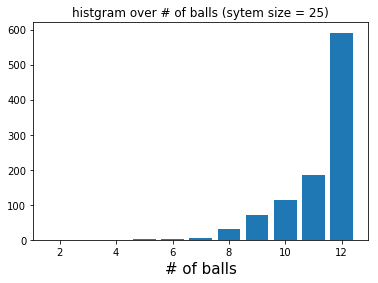

In [50]:
plt.title('histgram over # of balls (sytem size = {0})'.format(system_size))
plt.xlabel('# of balls', fontsize=15)
plt.hist(balls, range=(1,int(system_size/2)), rwidth=0.8, bins=int(system_size/2)-1, align='right');

次に基本周期分布を見てみます。

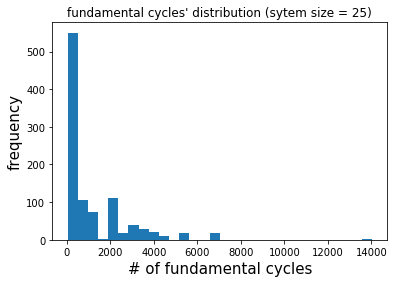

In [52]:
plt.title('fundamental cycles\' distribution (sytem size = {0})'.format(system_size))
plt.xlabel('# of fundamental cycles', fontsize=15)
plt.ylabel('frequency', fontsize=15)
plt.hist(cycle_dist, bins=30);

マシンパワーをお持ちの方は、是非いろいろ調べてみてください。もしかしたら数学的大発見が眠っているかもしれません。